# Section 5: Extract concatenated Index values for all stocks.

### Next step is to start building the implied covariance matrix that will be fed into the Black-Litterman model 

In [42]:
#Re-import everything from part 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import logging
import sys
import os 
from timer_class import Timer

timer = Timer()

#### More information on process: https://github.com/msekatchev/ubctg/tree/main/impliedCovariance


We have $N_s$ (9782 stocks), and $N_F$ factors, with many more stocks than factors. 

The target implied covariance matrix, $\Sigma = B + \Psi$, where:
1. $\Psi$, diagonal matrix of idiosyncratic returns
2. $A$ is an $N_F \times N_F$ matrix, corresponding to the covariance of the factors. 
3. $F$ is an $N_F \times N_S$ factor-stock loading.
4. Factor matrix $B = F^{-1}AF$

This covariance matrix can then be fed into the Black-Litterman model to finalize the predictive model. 

### 5.1 Find covariance factor matrix, $A$

In [45]:
#The code below was copied from the split clean file. See Part 1 (end of section 3) for exact same code + pickling dataframe
#Simply load it here and ignore the next cell 

merged_index_df = pd.read_pickle('merged_index_df.pkl')
merged_index_df

,Energy_Index,Manufacturing_Index,Industrial_Index,Financials_Index,Life_Sciences_Index,Real_Estate_Index,Trade_Index,Technology_Index,No_Industry_Index
Date,,,,,,,,,
2019-01-02,0.006602,0.001376,-0.010762,-0.000395,-0.001970,-0.014113,0.008254,0.004748,0.005899
2019-01-03,-0.009767,-0.038831,-0.026461,-0.019520,-0.013465,0.000451,-0.018293,-0.025491,-0.013988
2019-01-04,0.032609,0.036603,0.033046,0.032033,0.035574,0.019628,0.035314,0.043051,0.027287
2019-01-07,0.008354,0.007724,0.005161,0.004261,0.015182,0.010286,0.020824,0.010588,0.006283
2019-01-08,0.012566,0.012406,0.009464,0.005032,0.010502,0.019014,0.011826,0.013124,0.005155
...,...,...,...,...,...,...,...,...,...
2021-01-25,-0.000161,0.010011,0.004632,-0.006889,0.012189,0.002773,-0.002866,0.004446,-0.000684
2021-01-26,-0.013542,-0.002927,-0.007613,-0.006219,-0.006305,0.007840,0.003198,0.001211,-0.003183
2021-01-27,-0.025848,-0.022602,-0.029112,-0.029406,-0.029853,-0.019873,-0.022875,-0.022060,-0.021064


In [46]:
# #First merge all the cumulative columns into one df 

# not_cum_industry_dataframes = [
#     energy_index_df,
#     manufacturing_index_df,
#     industrial_index_df,
#     financials_index_df,
#     life_sciences_index_df,
#     real_estate_index_df,
#     trade_index_df,
#     technology_index_df,
#     no_industry_index_df
# ]

# # Extract the 'Cumulative' column from each dataframe and concatenate them
# index_dfs = [df[['Diagonal']] for df in not_cum_industry_dataframes]
# merged_index_df = pd.concat(index_dfs, axis=1)

# # Rename columns by industry
# merged_index_df.columns = [
#     'Energy_Index',
#     'Manufacturing_Index',
#     'Industrial_Index',
#     'Financials_Index',
#     'Life_Sciences_Index',
#     'Real_Estate_Index',
#     'Trade_Index',
#     'Technology_Index',
#     'No_Industry_Index'
# ]


# #Take cutoff date since data from 2018 didn't load initially 
# cutoff_date = '2019-01-02' 

# merged_index_df = merged_index_df[merged_index_df.index >= cutoff_date] 


# # #Save above to a csv; this will help build factor return matrix 
# # merged_index_df.to_csv('output_file.csv', index=True)



# # merged_index_df

In [47]:
A = merged_index_df.cov()
A

,Energy_Index,Manufacturing_Index,Industrial_Index,Financials_Index,Life_Sciences_Index,Real_Estate_Index,Trade_Index,Technology_Index,No_Industry_Index
Energy_Index,0.000336,0.000283,0.000253,0.000338,0.000188,0.000301,0.000225,0.000243,0.000261
Manufacturing_Index,0.000283,0.000322,0.000253,0.000314,0.000201,0.000274,0.000255,0.000279,0.000246
Industrial_Index,0.000253,0.000253,0.000240,0.000284,0.000190,0.000247,0.000209,0.000231,0.000214
Financials_Index,0.000338,0.000314,0.000284,0.000393,0.000214,0.000330,0.000257,0.000278,0.000289
Life_Sciences_Index,0.000188,0.000201,0.000190,0.000214,0.000199,0.000182,0.000169,0.000194,0.000162
Real_Estate_Index,0.000301,0.000274,0.000247,0.000330,0.000182,0.000353,0.000224,0.000238,0.000248
Trade_Index,0.000225,0.000255,0.000209,0.000257,0.000169,0.000224,0.000231,0.000243,0.000199
Technology_Index,0.000243,0.000279,0.000231,0.000278,0.000194,0.000238,0.000243,0.000278,0.000215
No_Industry_Index,0.000261,0.000246,0.000214,0.000289,0.000162,0.000248,0.000199,0.000215,0.000223


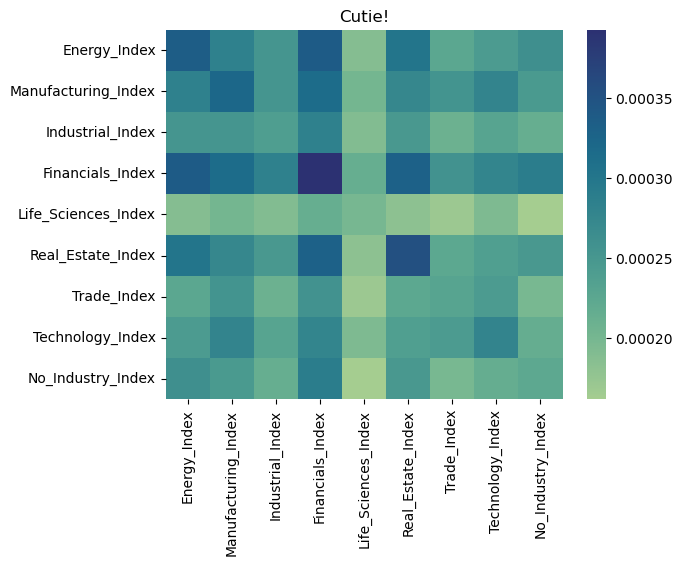

In [48]:
sns.heatmap(A, cmap = 'crest')
plt.title('Cutie!')
plt.show()

### 5.2 Find factor-stock loading matrix, F 

In [50]:
# #Stuffs we need
# merged_index_df

In [51]:
## Make returns same date; just taking off the 0s so it is fine 

#Load from Part 1
returns_df = pd.read_pickle('9782_returns_df.pkl')

#Take cutoff date since data from 2018 didn't load initially 
cutoff_date = '2019-01-02' 
cutoff_returns_df = returns_df[returns_df.index >= cutoff_date]
cutoff_returns_df

,JJSF,DGSE,ELA,PLXS,RMCF,HNGR,ADX,ORCL,MSFT,AADR,...,QEP,SIX,CORN,BNO,VPG,FN,BSFT,CBOE,SANW,TSLA
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,-0.024829,-0.043488,0.000000,0.012921,0.012887,-0.003694,0.002377,0.001550,-0.004430,0.006489,...,0.010657,0.007190,0.004361,0.015003,-0.002977,-0.007601,0.0,-0.019830,0.088398,-0.068149
2019-01-03,0.014326,0.088868,0.000000,-0.024932,0.000000,-0.021716,-0.022134,-0.009730,-0.036788,-0.011282,...,0.010545,-0.001785,0.008065,0.014139,-0.030856,-0.066379,0.0,-0.003129,0.040609,-0.031472
2019-01-04,0.012725,-0.060529,0.000000,0.025570,0.022596,0.027071,0.022635,0.043100,0.046509,0.038997,...,0.057391,0.033435,0.009231,0.025349,0.042794,0.040597,0.0,0.028978,0.078049,0.057697
2019-01-07,0.003935,0.000000,0.000000,0.012949,-0.019830,0.021086,0.014229,0.015842,0.001275,0.011791,...,0.402961,0.021799,0.000000,0.004944,0.010177,0.027087,0.0,-0.018402,-0.117647,0.054361
2019-01-08,0.022626,0.044444,0.000000,0.002099,0.027746,0.008260,0.012471,0.009062,0.007251,0.006954,...,0.026964,0.019641,-0.004268,0.018450,0.014300,0.015942,0.0,-0.031383,0.020513,0.001164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,0.024822,0.000000,0.016575,-0.012597,-0.022472,0.001312,0.001130,0.008946,0.015844,-0.013262,...,-0.031949,-0.006222,0.019558,0.009461,0.000593,-0.003379,0.0,0.004097,0.019444,0.040348
2021-01-26,0.051119,0.000000,0.043478,-0.041151,0.039080,-0.005677,-0.000564,0.014778,0.012199,-0.010730,...,-0.026403,-0.048947,0.029703,-0.002163,0.006517,-0.029113,0.0,0.001465,-0.079019,0.002600
2021-01-27,-0.040204,0.000000,0.029514,-0.010566,-0.035398,-0.051383,-0.027103,0.012136,0.002453,-0.040135,...,-0.054237,-0.052962,-0.002404,-0.003613,-0.019423,-0.027938,0.0,-0.043560,0.038462,-0.021436


### The Regression

The above two dataframes (index per industry, and returns per stock) are key to estimating the required matrix. 

Apply linear regression for each stock: $r_s(t) = \sum\limits_{j = 1}^{9} \beta_{s,j}r_{I,j} + \varepsilon_{s}(t)$

- $r_s(t)$ return of stock at time $t$
- $r_{I,j}(t)$ return of industry factor $j$ (see table for order) at time $t$
- $\beta_{s,j}$ factor loading of stock $s$ on industry $j$ (this is what we are trying to estimate with this model)
- $\varepsilon_{s}(t)$ idiosyncratic return (unexplained by the factors) - this corresponds to the $\psi$ matrix, and are the residuals of this regression

For each stock, run a regression of its returns on the 9 industry returns. The result will be a set $\beta_{s,1}, ..., \beta_{s,9}$ for each stock.
These regressions will form the columns of the factor loadings matrix $F$. Each row of this $F$ matrix corresponds to one of the industries, and each column a stock. 

In [53]:
#Package to do regression; linear regression on Betas as shown above
from sklearn.linear_model import LinearRegression


timer.start()

#Initialize the erms
num_stocks = cutoff_returns_df.shape[1]
num_factors = merged_index_df.shape[1]
F = np.zeros((num_factors, num_stocks))
res_var = np.zeros(num_stocks)

#Loop loop stock stock 
for i, stock in enumerate(cutoff_returns_df.columns):
    stock_returns = cutoff_returns_df[stock].values.reshape(-1, 1) #Stock return 
    industry_returns = merged_index_df.values #This is like an array of lists; [row1, row2,...] - these are indusryty returns (factors)

    #Regress 
    model = LinearRegression().fit(industry_returns, stock_returns) # - model.predict(industry_returns); keep these if want to auto add in psi 

    #Add to F
    F[:, i] = model.coef_.flatten()

    #Residuals 
    res = stock_returns - model.predict(industry_returns)

    #Store variance of these, i.e. psi values 
    res_var[i] = np.var(res)


#Put as diag matrix in format we need 
psi = np.diag(res_var)


#df the F 
F_df = pd.DataFrame(F, index=merged_index_df.columns, columns = cutoff_returns_df.columns)


timer.end()

Starting timer.
Ending timer.
Total elapsed time: 13.676121473312378 seconds



### 5.3 Now compute B, then add $\psi$ to obtain target implied covariance matrix, $\Sigma = B + \Psi$

In [55]:
#Tranpose F, we are computing directly in the dataframes since they are easier to read than the weird numpies 

timer.start()

F_tranny = F_df.T

B = (F_tranny.dot(A)).dot(F_df)

erm_what_the_sigma = B + psi

timer.end()

erm_what_the_sigma

Starting timer.
Ending timer.
Total elapsed time: 0.7480435371398926 seconds



,JJSF,DGSE,ELA,PLXS,RMCF,HNGR,ADX,ORCL,MSFT,AADR,...,QEP,SIX,CORN,BNO,VPG,FN,BSFT,CBOE,SANW,TSLA
JJSF,0.000700,-1.064610e-06,0.000162,0.000315,0.000133,0.000400,0.000256,0.000218,0.000225,0.000216,...,0.000788,0.000553,0.000040,0.000232,3.168733e-04,0.000246,0.0,2.191917e-04,1.756365e-04,0.000275
DGSE,-0.000001,1.455986e-03,0.000001,0.000003,-0.000008,-0.000004,0.000004,0.000004,0.000013,0.000007,...,-0.000035,-0.000012,0.000002,-0.000006,8.199031e-07,0.000005,0.0,-1.021150e-07,6.340566e-08,0.000013
ELA,0.000162,1.229681e-06,0.001561,0.000201,0.000069,0.000192,0.000180,0.000180,0.000252,0.000178,...,0.000454,0.000239,0.000023,0.000177,1.849271e-04,0.000210,0.0,1.303568e-04,6.044076e-05,0.000334
PLXS,0.000315,3.372086e-06,0.000201,0.000721,0.000140,0.000382,0.000268,0.000242,0.000278,0.000236,...,0.000857,0.000548,0.000043,0.000262,3.354600e-04,0.000290,0.0,2.031077e-04,1.533405e-04,0.000380
RMCF,0.000133,-7.714566e-06,0.000069,0.000140,0.001175,0.000163,0.000095,0.000075,0.000075,0.000079,...,0.000393,0.000247,0.000014,0.000107,1.355746e-04,0.000098,0.0,7.579879e-05,6.746525e-05,0.000140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FN,0.000246,5.198962e-06,0.000210,0.000290,0.000098,0.000287,0.000244,0.000255,0.000309,0.000231,...,0.000630,0.000383,0.000034,0.000226,2.716795e-04,0.000715,0.0,1.630896e-04,1.287351e-04,0.000397
BSFT,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000
CBOE,0.000219,-1.021150e-07,0.000130,0.000203,0.000076,0.000259,0.000183,0.000155,0.000186,0.000155,...,0.000454,0.000349,0.000026,0.000145,2.024563e-04,0.000163,0.0,4.392968e-04,9.260510e-05,0.000209
SANW,0.000176,6.340566e-08,0.000060,0.000153,0.000067,0.000209,0.000122,0.000116,0.000097,0.000103,...,0.000442,0.000270,0.000019,0.000130,1.611557e-04,0.000129,0.0,9.260510e-05,1.949239e-03,0.000089


# Section 6: Implied Covariance Done. Some neat visualizations. 

Don't waste time running the stuff that looks like it didn't work... it is just brainstorming/build-up to what did work afterwards. 
Decided to keep it all anyways to show that with a universe this size (9782 stocks), it is not practical and very expensive even to just display the entire covariance matrix.

Update: A lot of it was just wasting space so I cut most of what followed. To see original brainstorm, see "Clean File.ipynb".

### 6.5: After 4 failed attempts at usable and meaningful results, progress!

In [58]:
# energy_transportation_tickers = []
# manufacturing_tickers = []
# industrial_applications_services_tickers = []
# financials_tickers = []
# life_sciences_tickers = []
# real_estate_construction_tickers = []
# trade_services_tickers = []
# technology_tickers = []
# #No industry: Has a permno, and is present in ticker_dfs, but no matching SIC cdoe found, also catches errors 
# no_industry_tickers = []

#### Load tickers into lists for "industries" below. These were also built in Part 1. 

In [81]:
# timer.start()


# #Context manager to read industries: dict of ticker lists (key = industry, value = list of tickers) 
# with open('9782_industries.pkl', 'rb') as f:
#     industries = pickle.load(f)


# # Get overall min and max for scaling
# overall_min = erm_what_the_sigma.min().min()
# overall_max = erm_what_the_sigma.max().max()

# # Determine number of rows and columns for subplots
# num_industries = len(industries)
# cols = 3  # Number of columns for the subplot grid
# rows = (num_industries // cols) + (num_industries % cols > 0)  # Calculate required rows

# # Create subplots
# fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
# axes = axes.flatten()  # Flatten the array of axes for easy iteration

# # Loop through each industry and create a heatmap in the corresponding subplot
# for idx, (industry_name, tickers) in enumerate(industries.items()):
#     if tickers:  # Only proceed if the list is not empty
#         industry_cov_matrix = erm_what_the_sigma.loc[tickers, tickers]
        
#         sns.heatmap(industry_cov_matrix, cmap='coolwarm', annot=False,
#                     ax=axes[idx], square=True, cbar_kws={"shrink": .8}, 
#                     vmin=overall_min, vmax=overall_max)  # Set color limits
#         axes[idx].set_title(f'Covariance Matrix Heatmap for {industry_name}')
#         axes[idx].set_xlabel('Stocks')
#         axes[idx].set_ylabel('Stocks')

# # Hide any unused subplots
# for j in range(idx + 1, len(axes)):
#     axes[j].axis('off')

# timer.end()


# plt.tight_layout()  # Adjust layout to avoid overlap
# plt.show()

##### Everything is clustered around the blue end (low covariance values) with a few high value outliers.

Focusing around the mean and displaying results within 2 standard deviations should yield approximately 95% of all values assuming normal distribution approximation from CLT (maybe?).

##### Try taking stdev of the whole thing then plot around that range; may show some things by industry if we look a bit closer

In [83]:
# timer.start()


# # Calculate overall mean and standard deviation
# overall_mean = erm_what_the_sigma.values.mean()
# overall_std = erm_what_the_sigma.values.std()

# # Set vmin and vmax to -2 and +2 standard deviations
# vmin = overall_mean - 2 * overall_std
# vmax = overall_mean + 2 * overall_std

# # Determine number of rows and columns for subplots
# num_industries = len(industries)
# cols = 3  # Number of columns for the subplot grid
# rows = (num_industries // cols) + (num_industries % cols > 0)  # Calculate required rows

# # Create subplots
# fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
# axes = axes.flatten()  # Flatten the array of axes for easy iteration

# # Loop through each industry and create a heatmap in the corresponding subplot
# for idx, (industry_name, tickers) in enumerate(industries.items()):
#     if tickers:  # Only proceed if the list is not empty
#         industry_cov_matrix = erm_what_the_sigma.loc[tickers, tickers]

#         sns.heatmap(industry_cov_matrix, cmap='viridis', annot=False,
#                     ax=axes[idx], square=True, cbar_kws={"shrink": .8}, 
#                     vmin=vmin, vmax=vmax)  # Set custom color limits
#         axes[idx].set_title(f'Cov Matrix Heatmap: {industry_name}')
#         axes[idx].set_xlabel('Stocks')
#         axes[idx].set_ylabel('Stocks')
#         # axes[idx].set_xticklabels([])
#         # axes[idx].set_yticklabels([])

# # Hide any unused subplots
# for j in range(idx + 1, len(axes)):
#     axes[j].axis('off')


# timer.end()



# plt.tight_layout()  # Adjust layout to avoid overlap
# plt.show()

### Wrote a package in a package called plotter.py

See documentation for plotting function details; cleanest format was plotting by pairs but the function works with other number of arguments.

In [85]:
# from plotter import plot_industries_with_zoom

# industries_to_plot = ["Energy", "Manufacturing"]
# plot_industries_with_zoom(
#     industries=industries_to_plot, 
#     industry_tickers=industries,  # Assuming 'industries' is your dictionary of tickers
#     covariance_matrix=erm_what_the_sigma,  # Your covariance matrix
#     vmin=vmin, 
#     vmax=vmax
# )

In [87]:
# industries_to_plot = ["Industrial Applications & Services", "Financials"]
# plot_industries_with_zoom(
#     industries=industries_to_plot, 
#     industry_tickers=industries, 
#     covariance_matrix=erm_what_the_sigma, 
#     vmin=vmin, 
#     vmax=vmax
# )

In [89]:
# industries_to_plot = ["Life Sciences", "Real Estate & Construction"]
# plot_industries_with_zoom(
#     industries=industries_to_plot, 
#     industry_tickers=industries, 
#     covariance_matrix=erm_what_the_sigma, 
#     vmin=vmin, 
#     vmax=vmax
# )

In [91]:
# industries_to_plot = ["Trade & Services", "Technology"]
# plot_industries_with_zoom(
#     industries=industries_to_plot, 
#     industry_tickers=industries, 
#     covariance_matrix=erm_what_the_sigma, 
#     vmin=vmin, 
#     vmax=vmax
# )

# Section 7: Invert the Implied Covariance Matrix

### 7.1: Erm

Erm-er?

In [93]:
#First convert psi to df. Then e have dataframes: A, B, psi_df, F_df

psi_df = pd.DataFrame(psi)


# #Get the inverse. Note the inverse of a diagonal matrix is just the inverse of the diagonal values 
# psi_inverse_df = pd.DataFrame(np.diag(1 / np.diag(psi_df)))
# psi_inverse_df

#Replace 0 values with small epsilon due to data errors and hiccups 
epsilon = 1e-6
psi_diag = np.diag(psi_df)

# Replace zero values with epsilon to avoid division by zero
psi_diag_modified = np.where(psi_diag == 0, epsilon, psi_diag)

# Create a modified psi DataFrame with the updated diagonal values
psi_df_modified = pd.DataFrame(np.diag(psi_diag_modified), index=psi_df.index, columns=psi_df.columns)

# Compute the inverse of the modified psi_df (inverse of diagonal matrix is the reciprocal of the diagonal values)
psi_inverse_df = pd.DataFrame(np.diag(1 / psi_diag_modified), index=psi_df.index, columns=psi_df.columns)

# Output the inverse matrix
psi_inverse_df

,0,1,2,3,4,5,6,7,8,9,...,9772,9773,9774,9775,9776,9777,9778,9779,9780,9781
0,2759.123296,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.000000,692.553064,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,0.000000,0.000000,732.236624,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,2690.006735,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,917.965886,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9777,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2413.686678,0.0,0.000000,0.000000,0.000000
9778,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,1000000.0,0.000000,0.000000,0.000000
9779,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3679.988441,0.000000,0.000000
9780,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,548.060081,0.000000


In [71]:
# #First convert psi to df. Then e have dataframes: A, B, psi_df, F_df

# psi_df = pd.DataFrame(psi)


# # Get diagonal values
# diagonal_values = np.diag(psi_df)

# # Calculate the inverse, handling division by zero
# inverse_diagonal_values = np.where(diagonal_values != 0, 1 / diagonal_values, np.nan)

# # Create the inverse diagonal DataFrame
# psi_inverse_df = pd.DataFrame(np.diag(inverse_diagonal_values))
# psi_inverse_df

In [72]:
psi_diag_test = np.diag(psi_df.to_numpy())

diag_list = psi_diag.tolist()

print(f"Length of diagonal: {len(diag_list)}")

num_zero = diag_list.count(0)
print(f"Number of zeros: {num_zero}")

Length of diagonal: 9782
Number of zeros: 524


In [73]:
#Compute g = Tr(B \psi^{-1})

timer.start()

g = np.trace(B.values @ psi_inverse_df.values)

timer.end()

g

Starting timer.
Ending timer.
Total elapsed time: 19.267972230911255 seconds



24141.861534631353

In [95]:
# timer.start()

# # Initialize Sigma^{-1}
# Sigma_inverse_df = psi_inverse_df.copy()

# # Compute B_i for each stock using DataFrames
# for i in range(F_df.shape[0]):  # Iterate over each factor (9 factors)
#     # Construct B_i as an outer product scaled by the diagonal of A
#     F_i = F_df.iloc[i, :]  # Get the ith factor (row)
#     B_i = F_i.values.reshape(-1, 1) @ F_i.values.reshape(1, -1) * A.iloc[i, i]  # Shape (9782, 9782)

#     # Convert B_i to DataFrame
#     B_i_df = pd.DataFrame(B_i, index=F_df.columns, columns=F_df.columns)

#     # Compute g for B_i as the trace of (B_i @ psi_inverse_df)
#     g_i = np.trace(B_i_df.values @ psi_inverse_df.values)  # Ensure both are (9782, 9782)

#     # Update Sigma_inverse with the formula for (B_i + psi)^-1
#     Sigma_inverse_df -= (1 / (1 + g_i)) * (psi_inverse_df.values @ B_i_df.values @ psi_inverse_df.values)


# timer.end()

# # Output the final Sigma^{-1}
# Sigma_inverse_df

In [ ]:
erm_what_the_sigma

In [ ]:
#This part is weird; kinda looked like I had to remove a psi inverse but there's no justification behind this 
#Just felt right given the values; the correct version is probably just Sigma_inverse_df
final_sigma_inverse = Sigma_inverse_df - psi_inverse_df
final_sigma_inverse

#### Comment out the 2 lines below; no need to rewrite the same thing already in folder.

In [ ]:
# erm_what_the_sigma.to_csv('implied_covariance', index=True)

In [ ]:
# final_sigma_inverse.to_csv('implied_inverse.csv', index=True)

## Section B2: Ignore Everything Below

Nothing below is important. Just includes one of the first attempts at plotting interactive subindustries. Sent a small section of this file to someone who needed something as well. 

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Try plotting just one or two industries to test
#Test worked! Shift everything into standalone function on side. 
test_industries = {
    "Energy": energy_transportation_tickers
    # "Whole": unique_tickers --> DO NOT DO, BAD.
}

fig = make_subplots(rows=1, cols=2, subplot_titles=list(test_industries.keys()))

for idx, (industry_name, tickers) in enumerate(test_industries.items()):
    if tickers:
        industry_cov_matrix = erm_what_the_sigma.loc[tickers, tickers]

        heatmap = go.Heatmap(
            z=industry_cov_matrix.values,
            x=tickers,
            y=tickers,
            colorscale='Viridis',
            zmin=vmin,
            zmax=vmax
        )
        
        row = 1
        col = idx + 1
        fig.add_trace(heatmap, row=row, col=col)

fig.update_layout(
    title="Test Subindustry Covariance Heatmaps",
    width=1200, height=600,
    dragmode='zoom',
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            buttons=[
                dict(
                    args=[{'xaxis.autorange': True, 'yaxis.autorange': True}],
                    label="Reset Zoom",
                    method="relayout"
                )
            ],
            pad={"r": 10, "t": 10},
            showactive=False,
            x=0.15,
            xanchor="left",
            y=1.15,
            yanchor="top"
        )
    ]
)

fig.show()


In [ ]:
print(len(energy_transportation_tickers))
print(len(manufacturing_tickers))
print(len(industrial_applications_services_tickers))
print(len(financials_tickers))
print(len(life_sciences_tickers))
print(len(real_estate_construction_tickers))
print(len(trade_services_tickers))
print(len(technology_tickers))
print(len(no_industry_tickers))


# Combine lists into a dictionary
magic_ticker_dict = {
    'Energy Transportation': energy_transportation_tickers,
    'Manufacturing': manufacturing_tickers,
    'Industrial Applications Services': industrial_applications_services_tickers,
    'Financials': financials_tickers,
    'Life Sciences': life_sciences_tickers,
    'Real Estate Construction': real_estate_construction_tickers,
    'Trade Services': trade_services_tickers,
    'Technology': technology_tickers,
    'No Industry': no_industry_tickers
}

# Convert to DataFrame
magic_tickers_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in magic_ticker_dict.items()]))

# Save to a CSV file
magic_tickers_df.to_csv('fred_groups.csv', index=False)

print("File saved as 'fred_groups.csv'")

In [ ]:
# https://seaborn.pydata.org/tutorial/color_palettes.html